<a href="https://www.kaggle.com/code/evelynartoria/arc-dataset-class-and-visualizer-pytorch?scriptVersionId=189005502" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A dataset with some weird functions

- Just a dataset class with a visualizer I wrote for my attempts at this competition; it's made for multiple different aproaches
- ** this code is a mess **


# All dependencies I've used so far
- most aren't needed for the code below

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
#from learn2learn.algorithms import MAML
from torchvision.transforms import Resize, Pad
import numpy as np

2024-07-19 23:43:32.961107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 23:43:32.961275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 23:43:33.149314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# load files

In [2]:
def load(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)
train_challenges = pd.DataFrame(load("/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json"))
train_solutions = load("/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json") # cannot turn into a pandas dataframe
train_challenges.head(5)
evaluation_challenges = pd.DataFrame(load("/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"))
evaluation_solutions = load("/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json")

In [3]:
device = "cpu"

In [4]:
class ARCDataset(Dataset):
    def __init__(self, challenges: pd.DataFrame, solutions: dict = None, train: bool = True):
        super().__init__()
        self.challenges = challenges
        self.solutions = solutions
        self.train = train
        self.idx_to_column = {v: k for v, k in enumerate(challenges.columns)}

        self.special_idx = [] # just some indices where test has more than one input and each input has a solution | just keeping track of it because I want to

        self.sorted_data = {
            "very easy": [],
            "easy": [],
            "medium": [],
            "hard": [],
            "extremely hard": []
        }

        self.scope = ""

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index < len(self):
            result = self[self.index]
            self.index += 1
            return result
        else:
            raise StopIteration
        
    def __len__(self):
        if self.scope == "":
            return len(self.challenges.columns)-1
        else:
            return len(self.sorted_data[self.scope])

    def __getitem__(self, idx):
        data_dict = {
            "inputs": [],
            "outputs": [],
            "tests": [],
            "solutions": [],
            "challenge_name": ""
        }

        if self.scope == "":
            column = self.idx_to_column[idx]
        else:
            column = self.sorted_data[self.scope][idx]

        train_data = self.challenges[column]["train"]
        test_data = self.challenges[column]["test"]
        for data in train_data:
            data_dict["inputs"].append(torch.tensor(data["input"], dtype=torch.float32))
            data_dict["outputs"].append(torch.tensor(data["output"], dtype=torch.float32))

        for data in test_data:
            data_dict["tests"].append(torch.tensor(data["input"], dtype=torch.float32))

        if self.solutions is not None:
            solution_data = self.solutions[column]
            for solution in solution_data:
                #print(solution)
                data_dict["solutions"].append(torch.tensor(solution, dtype=torch.float32))

        data_dict["challenge_name"] = self.idx_to_column[idx]

        return data_dict



    def sort_data(self, criteria: str = "inputs"):
        for challenge_idx in range(len(self.challenges.columns)):
            challenge_dict = self.__getitem__(challenge_idx)
            total_shape_sum = 0
            challenge_mean_input_size = 0
            challenge_n_inputs = 0
            match criteria:
                case "inputs":
                    for challenge_input in challenge_dict["inputs"]:
                        #print(challenge_input.view(-1).shape)
                        total_shape_sum += challenge_input.view(-1).shape[0]
                        challenge_n_inputs += 1
                    challenge_mean_input_size = int(total_shape_sum/challenge_n_inputs)

                    # 9 --> 3x3
                    if challenge_mean_input_size <= 10:
                        self.sorted_data["very easy"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 81:
                        self.sorted_data["easy"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 256:
                        self.sorted_data["medium"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 486:
                        self.sorted_data["hard"].append(challenge_dict["challenge_name"])
                    else:
                        self.sorted_data["extremely hard"].append(challenge_dict["challenge_name"])

                case "outputs":
                    for challenge_input in challenge_dict["outputs"]:
                        #print(challenge_input.view(-1).shape)
                        total_shape_sum += challenge_input.view(-1).shape[0]
                        challenge_n_inputs += 1
                    challenge_mean_input_size = int(total_shape_sum/challenge_n_inputs)

                    # 9 --> 3x3
                    if challenge_mean_input_size <= 10:
                        self.sorted_data["very easy"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 81:
                        self.sorted_data["easy"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 256:
                        self.sorted_data["medium"].append(challenge_dict["challenge_name"])
                    elif challenge_mean_input_size <= 486:
                        self.sorted_data["hard"].append(challenge_dict["challenge_name"])
                    else:
                        self.sorted_data["extremely hard"].append(challenge_dict["challenge_name"])

    def set_scope(self, scope_idx: int = 0, remove: bool = False):
        if remove:
            self.scope = ""
            print(f"scope removed {self.scope}")
            return

        idx_to_column = {v: k for v, k in enumerate(self.sorted_data)}
        self.scope = idx_to_column[scope_idx]
        print(f"scope set to {self.scope}")
        return 


    @staticmethod
    def normalize_data(inputs, max_value: int = 30, min_value: int = 1):
        normalized_tensor = torch.tensor([ (value - min_value) / (max_value - min_value) for value in inputs])
        return normalized_tensor

    @staticmethod
    def reverse_normalize_data(inputs, max_value: int = 30, min_value: int = 1):
        reversed_tensor = torch.tensor([int(value * (max_value - min_value) + min_value) for value in inputs])
        return reversed_tensor

    def view_sorted_data_lengths(self):
        for k, v in self.sorted_data.items():
            print(f"{k} has {len(v)} elements")



    def view_data(self, challenge_idx, print_tensors: bool = False):
        for k, data in self.__getitem__(challenge_idx).items():
            if k not in ["challenge_name"]:
                #print(f"data is {data}")
                data_shapes = [tensor.shape for tensor in data]
                if print_tensors:
                    print(f"{k}, {len(data)} values --> {data_shapes} | {data}")
                else:
                    print(f"{k}, {len(data)} values --> {data_shapes}")

                if k == "solutions" and len(data) > 1 and challenge_idx not in self.special_idx:
                    self.special_idx.append(challenge_idx)
        print("\n")

    def view_random(self, num_samples: int, print_tensors: bool = False):
        x = torch.randperm(self.__len__())[:num_samples] # randperm makes sure there are no duplicates
        for idx in x:
            self.view_data(challenge_idx=idx.item(), print_tensors=print_tensors)

    def pad_tensor(self, tensor, target_shape, pad_value = -1):
        x_pad = target_shape - tensor.shape[0]
        y_pad = target_shape - tensor.shape[1]
        padding = ((y_pad//2),y_pad-y_pad//2, x_pad//2,x_pad-x_pad//2)
        mask = torch.nn.functional.pad(torch.ones_like(tensor), padding, mode='constant', value=0)
        return [torch.nn.functional.pad(tensor, padding, mode='constant', value=pad_value), mask]

    @staticmethod
    def reverse_pad(filled_tensor, mask, mask_value):
        x_shape_min = min((mask==0).sum(dim=1)).item()
        y_shape_min = min((mask==0).sum(dim=0)).item()

        final_x_shape = ((mask==0).sum(dim=1) == x_shape_min).sum()
        final_y_shape = ((mask==0).sum(dim=0) == y_shape_min).sum()


        #x_shape_min = min((filled_tensor==mask_value).sum(dim=1)).item()
        #y_shape_min = min((filled_tensor==mask_value).sum(dim=0)).item()

        #final_x_shape = ((filled_tensor==mask_value).sum(dim=1) == x_shape_min).sum()
        #final_y_shape = ((filled_tensor==mask_value).sum(dim=0) == x_shape_min).sum()


        reversed_tensor = filled_tensor[filled_tensor != mask_value].view(final_x_shape, final_y_shape)
        return reversed_tensor

    def pad_single_input(self, tensor):
        return self.pad_tensor(tensor, 30)

    @staticmethod
    def replicate(tensor, desired_shape, force: bool = True):
        if force:
            return tensor.repeat(1, 1, (desired_shape[0]//tensor.shape[1])+1, desired_shape[0]//tensor.shape[2]+1)[:, :, :desired_shape[0], :desired_shape[1]]
        else:
            return tensor.repeat(1, 1, (desired_shape[0]//tensor.shape[1])+1, desired_shape[0]//tensor.shape[2]+1)

    # I am opting to use self, just because I want to organize it this way with pad_tensor inside of the class
    def replicator_collate_fn(self, batch):
        batch_dict = {
            "inputs": [],
            "inputs_original_shapes": [],
            "outputs": [],
            "outputs_original_shapes": [],
            "tests": [],
            "tests_original_shapes": [],
            "solutions": [],
            "solutions_original_shapes": [],
            "challenge_names": [],
        }
        for challenge in batch:
            padded_inputs = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["inputs"]])
            padded_outputs = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["outputs"]])
            padded_tests = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["tests"]])
            padded_solutions = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["solutions"]])

            batch_dict["inputs"].append(padded_inputs)
            batch_dict["outputs"].append(padded_outputs)
            batch_dict["tests"].append(padded_tests)
            batch_dict["solutions"].append(padded_solutions)
            batch_dict["challenge_names"].append(challenge["challenge_name"])

            batch_dict["inputs_original_shapes"].append([values.shape for values in challenge["inputs"]])
            batch_dict["outputs_original_shapes"].append([values.shape for values in challenge["outputs"]])
            batch_dict["tests_original_shapes"].append([values.shape for values in challenge["tests"]])
            batch_dict["solutions_original_shapes"].append([values.shape for values in challenge["solutions"]])



        return batch_dict

    def basic_collate_fn(self, batch):
        batch_dict = {
            "inputs": [],
            "outputs": [],
            "tests": [],
            "solutions": [],
            "challenge_names": [],
        }
        for challenge in batch:
            inputs = torch.cat([value.view(-1) for value in challenge["inputs"]]).to(torch.long)
            #outputs = torch.cat([value.view(-1) for value in challenge["outputs"]]).to(torch.long)
            tests = torch.cat([value.view(-1) for value in challenge["tests"]]).to(torch.long)
            #solutions = torch.cat([value.view(-1) for value in challenge["solutions"]]).to(torch.long)
            batch_dict["inputs"].append(inputs)
            batch_dict["outputs"].append(challenge["outputs"])
            batch_dict["tests"].append(tests)
            batch_dict["solutions"].append(challenge["solutions"])
            batch_dict["challenge_names"].append(challenge["challenge_name"])

        return batch_dict

    def replicator_collate_fn_with_tests(self, batch):
        batch_dict = {
            "inputs": [],
            "inputs_original_shapes": [],
            "outputs": [],
            "outputs_original_shapes": [],
            "tests": [],
            "tests_original_shapes": [],
            "solutions": [],
            "solutions_original_shapes": [],
            "challenge_names": [],
        }
        for challenge in batch:
            padded_inputs = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["inputs"]]).to(torch.long)
            padded_outputs = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["outputs"]]).to(torch.long)
            padded_tests = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["tests"]]).to(torch.long)
            padded_solutions = torch.stack([self.replicate(value.unsqueeze(dim=0), (30, 30)).squeeze(dim=1) for value in challenge["solutions"]]).to(torch.long)
            padded_inputs = torch.cat([padded_inputs, padded_tests])
            padded_outputs = torch.cat([padded_outputs, padded_solutions])

            batch_dict["inputs"].append(padded_inputs)
            batch_dict["outputs"].append(padded_outputs)
            batch_dict["tests"].append(padded_tests)
            batch_dict["solutions"].append(padded_solutions)
            batch_dict["challenge_names"].append(challenge["challenge_name"])

            batch_dict["inputs_original_shapes"].append([values.shape for values in challenge["inputs"]])
            batch_dict["outputs_original_shapes"].append([values.shape for values in challenge["outputs"]])
            batch_dict["tests_original_shapes"].append([values.shape for values in challenge["tests"]])
            batch_dict["solutions_original_shapes"].append([values.shape for values in challenge["solutions"]])
        return batch_dict

    def pad_collate_fn(self, batch):
        batch_dict = {
            "inputs": [],
            "inputs_masks": [],
            "outputs": [],
            "outputs_masks": [],
            "tests": [],
            "tests_masks": [],
            "solutions": [],
            "solutions_masks": [],
            "challenge_names": [],
        }
        for challenge in batch:
            padded_inputs = [self.pad_tensor(value, 30) for value in challenge["inputs"]] # mask at padded_inputs[idx][1] while the input is at padded_inputs[idx][0]
            padded_outputs = [self.pad_tensor(value, 30) for value in challenge["outputs"]]
            padded_tests = [self.pad_tensor(value, 30) for value in challenge["tests"]]
            padded_solutions = [self.pad_tensor(value, 30) for value in challenge["solutions"]]

            batch_dict["inputs"].append(torch.stack([padded[0] for padded in padded_inputs], dim=0).unsqueeze(dim=0))
            batch_dict["inputs_masks"].append(torch.stack([padded[1] for padded in padded_inputs], dim=0).unsqueeze(dim=0))

            batch_dict["outputs"].append(torch.stack([padded[0] for padded in padded_outputs], dim=0).unsqueeze(dim=0))
            batch_dict["outputs_masks"].append(torch.stack([padded[1] for padded in padded_outputs], dim=0).unsqueeze(dim=0))

            batch_dict["tests"].append(torch.stack([padded[0] for padded in padded_tests], dim=0).unsqueeze(dim=0))
            batch_dict["tests_masks"].append(torch.stack([padded[1] for padded in padded_tests], dim=0).unsqueeze(dim=0))
            
            batch_dict["solutions"].append(torch.stack([padded[0] for padded in padded_solutions], dim=0).unsqueeze(dim=0))
            batch_dict["solutions_masks"].append(torch.stack([padded[1] for padded in padded_solutions], dim=0).unsqueeze(dim=0))

            batch_dict["challenge_names"].append(challenge["challenge_name"])

        return batch_dict




In [5]:
class Visualizer:
    def __init__(self, dataset: ARCDataset, cmap = None):
        self.dataset = dataset
        self.cmap = cmap

        if cmap is None:
            colors = [
                [0/255, 0/255, 0/255],        # Black (index 0)
                [0/255, 116/255, 217/255],    # Blue (index 1)
                [255/255, 65/255, 54/255],    # Red (index 2)
                [46/255, 204/255, 64/255],    # Green (index 3)
                [255/255, 220/255, 0/255],    # Yellow (index 4)
                [170/255, 170/255, 170/255],  # Grey (index 5)
                [240/255, 18/255, 190/255],   # Pink (index 6)
                [255/255, 133/255, 27/255],   # Orange (index 7)
                [127/255, 219/255, 255/255],  # Light Blue (index 8)
                [135/255, 12/255, 37/255]     # Maroon (index 9)
            ]

            self.cmap = ListedColormap(colors)

    def __len__(self):
        return len(self.dataset)

    def view_matrix(self, matrix, annot: bool = True, is_tensor: bool = True):
        if is_tensor:
            matrix = matrix.to(torch.long).cpu().numpy()
        sns.heatmap(matrix, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d')

    def view_challenge(self, challenge_idx, challenge_predictions = None, test_predictions = None, annot: bool = False, dataset: ARCDataset = None, n_rows: int = 6):
        if dataset is None:
            dataset = self.dataset
        challenge = dataset[challenge_idx]
        challenge_inputs = challenge["inputs"]
        challenge_outputs = challenge["outputs"]
        print(f"len is {len(challenge_outputs)}")
        challenge_tests = challenge["tests"]
        test_solutions = challenge["solutions"]
        fig, axes = plt.subplots(n_rows, len(challenge_inputs), figsize=(int(len(challenge_inputs)*3.5)+10, int(len(challenge_inputs)*2)+10))
        for idx, (challenge_input, challenge_output) in enumerate(zip(challenge_inputs, challenge_outputs)):
            challenge_input = challenge_input.to(torch.long).cpu().numpy()
            challenge_output = challenge_output.to(torch.long).cpu().numpy()
            sns.heatmap(challenge_input, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[0][idx], cbar=False, xticklabels=False, yticklabels=False)
            sns.heatmap(challenge_output, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[1][idx], cbar=False, xticklabels=False, yticklabels=False)
            axes[0][idx].set_title(f"inputs | {challenge['challenge_name']}")
            axes[1][idx].set_title(f"outputs | {challenge['challenge_name']}")


        if self.dataset.train:
            for idx, (challenge_test, test_solution) in enumerate(zip(challenge_tests, test_solutions)):
                challenge_test = challenge_test.to(torch.long).cpu().numpy()
                test_solution = test_solution.to(torch.long).cpu().numpy()
                sns.heatmap(challenge_test, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[2][idx], cbar=False, xticklabels=False, yticklabels=False)
                sns.heatmap(test_solution, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[3][idx], cbar=False, xticklabels=False, yticklabels=False)
                axes[2][idx].set_title(f"test | {challenge['challenge_name']}")
                axes[3][idx].set_title(f"test solution | {challenge['challenge_name']}")

        else:
            for idx, challenge_test in enumerate(challenge_tests):
                challenge_test = challenge_test.to(torch.long).cpu().numpy()
                sns.heatmap(challenge_test, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[2][idx], cbar=False, xticklabels=False, yticklabels=False)
                axes[2][idx].set_title(f"test | {challenge['challenge_name']}")

        if challenge_predictions is not None:
            for idx, (challenge_pred) in enumerate(challenge_predictions):
                challenge_pred = challenge_pred.to(torch.long).cpu().numpy()
                sns.heatmap(challenge_pred, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[4][idx], cbar=False, xticklabels=False, yticklabels=False)
                axes[4][idx].set_title(f"model pred for {idx} | {challenge['challenge_name']}")

        if test_predictions is not None:
            for idx, (test_pred) in enumerate(test_predictions):
                test_pred = test_pred.to(torch.long).cpu().numpy()
                sns.heatmap(test_pred, annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[5][idx], cbar=False, xticklabels=False, yticklabels=False)
                axes[5][idx].set_title(f"model pred for test {idx} | {challenge['challenge_name']}")



        #if len(challenge["solution"]) != 0:
            #for solution_idx, solution in enumerate(challenge["solution"]):
                #sns.heatmap(solution.to(torch.long).view(solution.shape[1], solution.shape[2]).cpu().numpy(), annot=annot, cmap=self.cmap, vmin=0, vmax=10, fmt='d', ax=axes[2][solution_idx+1], cbar=False, xticklabels=False, yticklabels=False)
                #axes[2][solution_idx+1].set_title(f"test solution | {challenge['challenge_name']}")
            



        return

In [6]:
ARC_train = ARCDataset(challenges=train_challenges, solutions=train_solutions, train=True)
ARC_eval = ARCDataset(challenges=evaluation_challenges, solutions=train_solutions, train=True)

# data about challenge 1
challenge1 = ARC_train[1]
for k, v in challenge1.items():
    print(k)
challenge1

inputs
outputs
tests
solutions
challenge_name


{'inputs': [tensor([[0., 0., 0., 0., 0., 0.],
          [0., 0., 3., 0., 0., 0.],
          [0., 3., 0., 3., 0., 0.],
          [0., 0., 3., 0., 3., 0.],
          [0., 0., 0., 3., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]),
  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 3., 0., 3., 0., 0., 0., 0., 0.],
          [0., 0., 0., 3., 0., 3., 0., 0., 0., 0.],
          [0., 0., 3., 0., 0., 0., 3., 0., 0., 0.],
          [0., 0., 0., 0., 0., 3., 0., 3., 0., 0.],
          [0., 0., 0., 3., 0., 3., 3., 0., 0., 0.],
          [0., 0., 3., 3., 3., 0., 0., 0., 0., 0.],
          [0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  tensor([[0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
          [0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
          [0., 3., 3., 0., 3., 3., 0., 3., 0., 0.],
          [3., 0., 0., 3., 0., 0., 3., 0., 3., 0.],
          [0., 0., 0., 3., 0., 0., 3., 3.,

len is 5


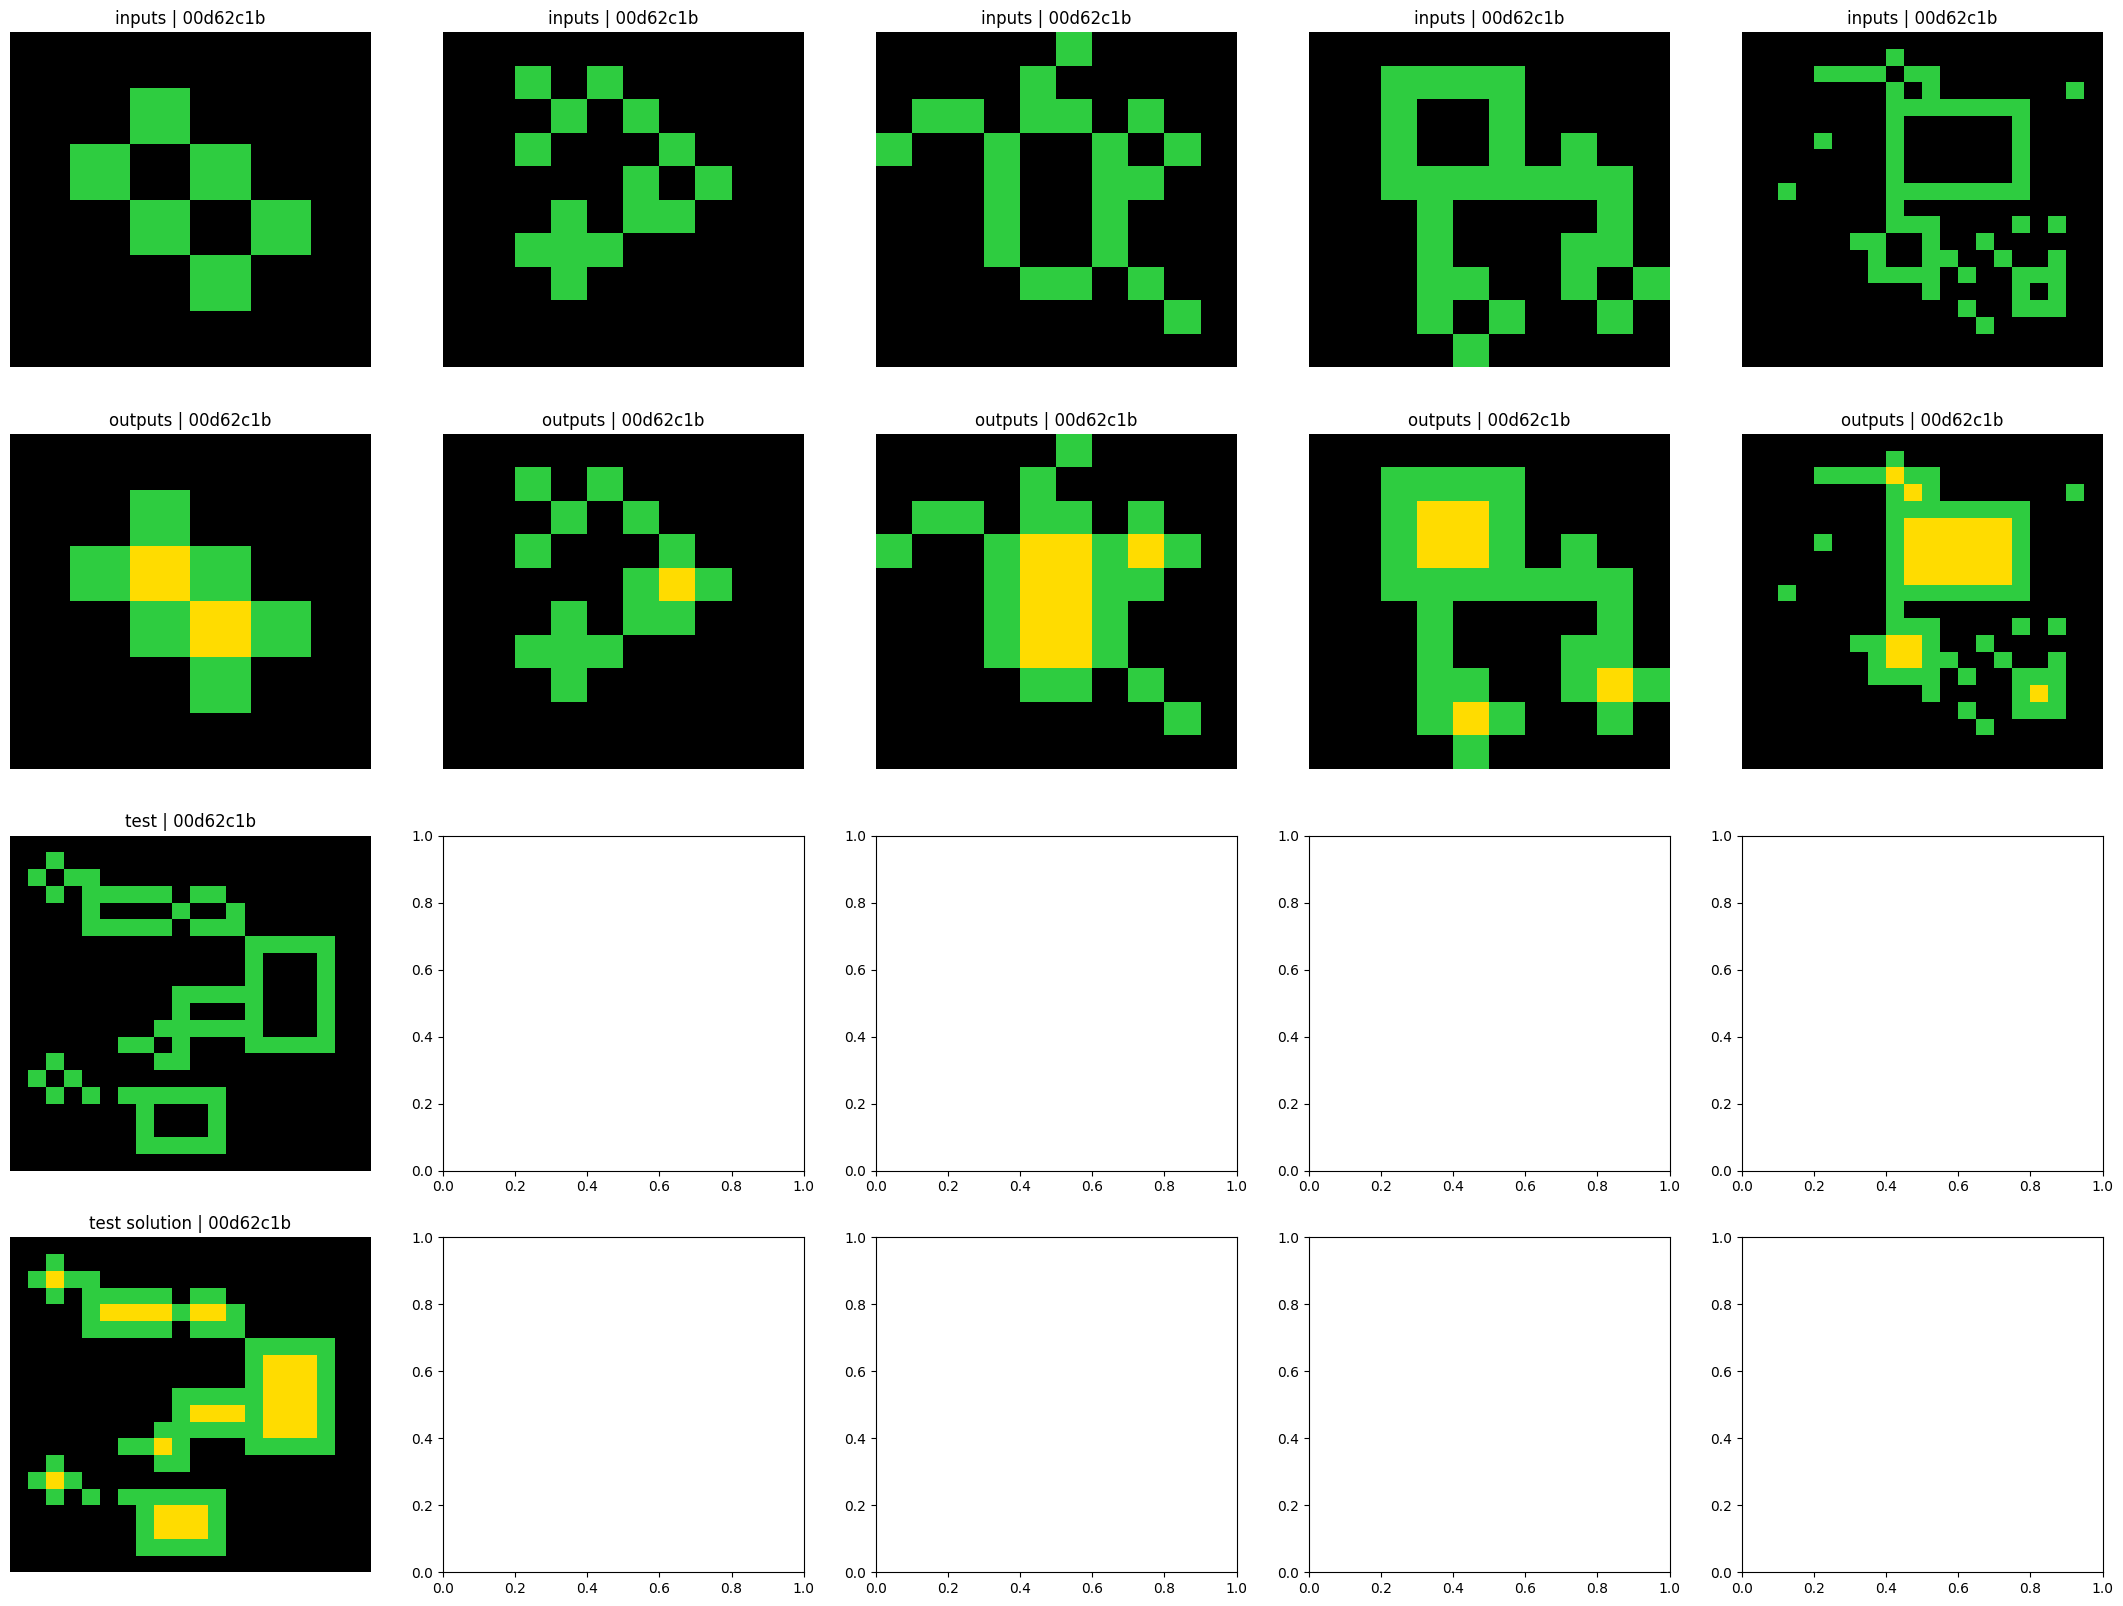

In [7]:
train_visualizer = Visualizer(dataset=ARC_train)
train_visualizer.view_challenge(challenge_idx=1, n_rows=4)

['007bbfb7', '00d62c1b', '017c7c7b', '025d127b']
torch.Size([5, 1, 30, 30])


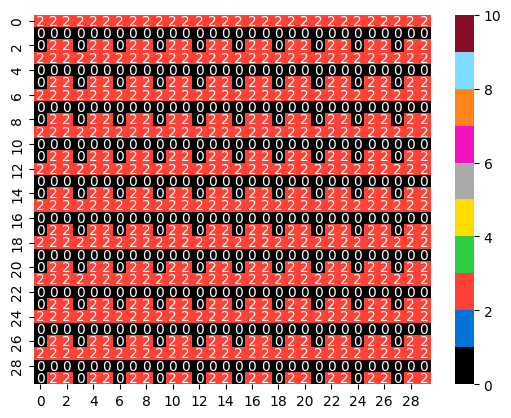

In [8]:
# This dataloader is using the replicator collate_fn
train_dataloader = DataLoader(dataset=ARC_train, batch_size=4, generator=torch.Generator(device=device), collate_fn=ARC_train.replicator_collate_fn, shuffle=False)
sample = next(iter(train_dataloader))
print(sample["challenge_names"])
#sample["inputs"][0] gets the inputs for the first challenge in the batch, since shuffle=False, it's going to get 007bbfb7
print(sample["inputs"][0].shape) # each challenge is in the batch dimension; there is 1 color channel
train_visualizer.view_matrix(sample["inputs"][0][4, 0, :, :])

['007bbfb7', '00d62c1b', '017c7c7b', '025d127b']
torch.Size([1, 5, 30, 30])
inputs
inputs_masks
outputs
outputs_masks
tests
tests_masks
solutions
solutions_masks
challenge_names


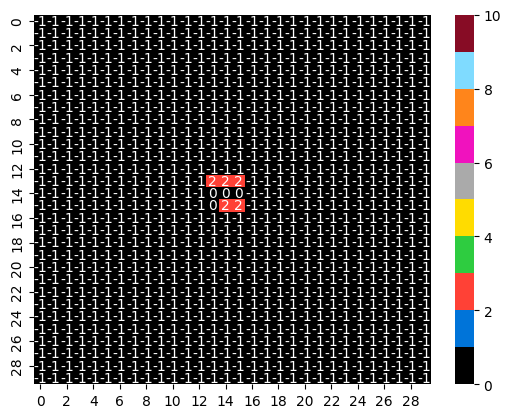

In [9]:
train_dataloader = DataLoader(dataset=ARC_train, batch_size=4, generator=torch.Generator(device=device), collate_fn=ARC_train.pad_collate_fn, shuffle=False)
sample = next(iter(train_dataloader))
print(sample["challenge_names"])
#sample["inputs"][0] gets the inputs for the first challenge in the batch, since shuffle=False, it's going to get 007bbfb7
print(sample["inputs"][0].shape) # each challenge is in the color channel dimension; there is 1 color channel

for k, v in sample.items():
    print(k)

train_visualizer.view_matrix(sample["inputs"][0][0, 4, :, :])

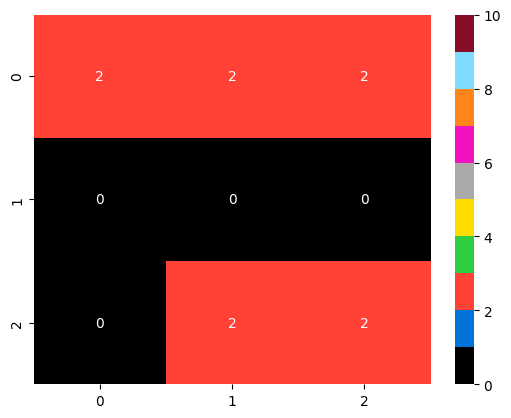

In [10]:
# Reverse the padding
train_visualizer.view_matrix(ARC_train.reverse_pad(sample["inputs"][0][0, 4, :, :], mask=sample["inputs_masks"][0][0, 4, :, :], mask_value=-1))

In [11]:
# This dataloader is using the replicator collate_fn
train_dataloader = DataLoader(dataset=ARC_train, batch_size=4, generator=torch.Generator(device=device), collate_fn=ARC_train.basic_collate_fn, shuffle=False)
sample = next(iter(train_dataloader))
print(sample["challenge_names"])
#sample["inputs"][0] gets the inputs for the first challenge in the batch, since shuffle=False, it's going to get 007bbfb7
print(len(sample["inputs"])) # challenges aren't padded, so they are in a list; also they are in a linear format
print(sample["inputs"][0].shape)
print(sample["inputs"][0])

['007bbfb7', '00d62c1b', '017c7c7b', '025d127b']
4
torch.Size([45])
tensor([0, 7, 7, 7, 7, 7, 0, 7, 7, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 2, 6, 6, 0, 6, 0, 0, 0, 6, 6, 2, 2, 2, 0, 0, 0, 0, 2, 2])


5
len is 5


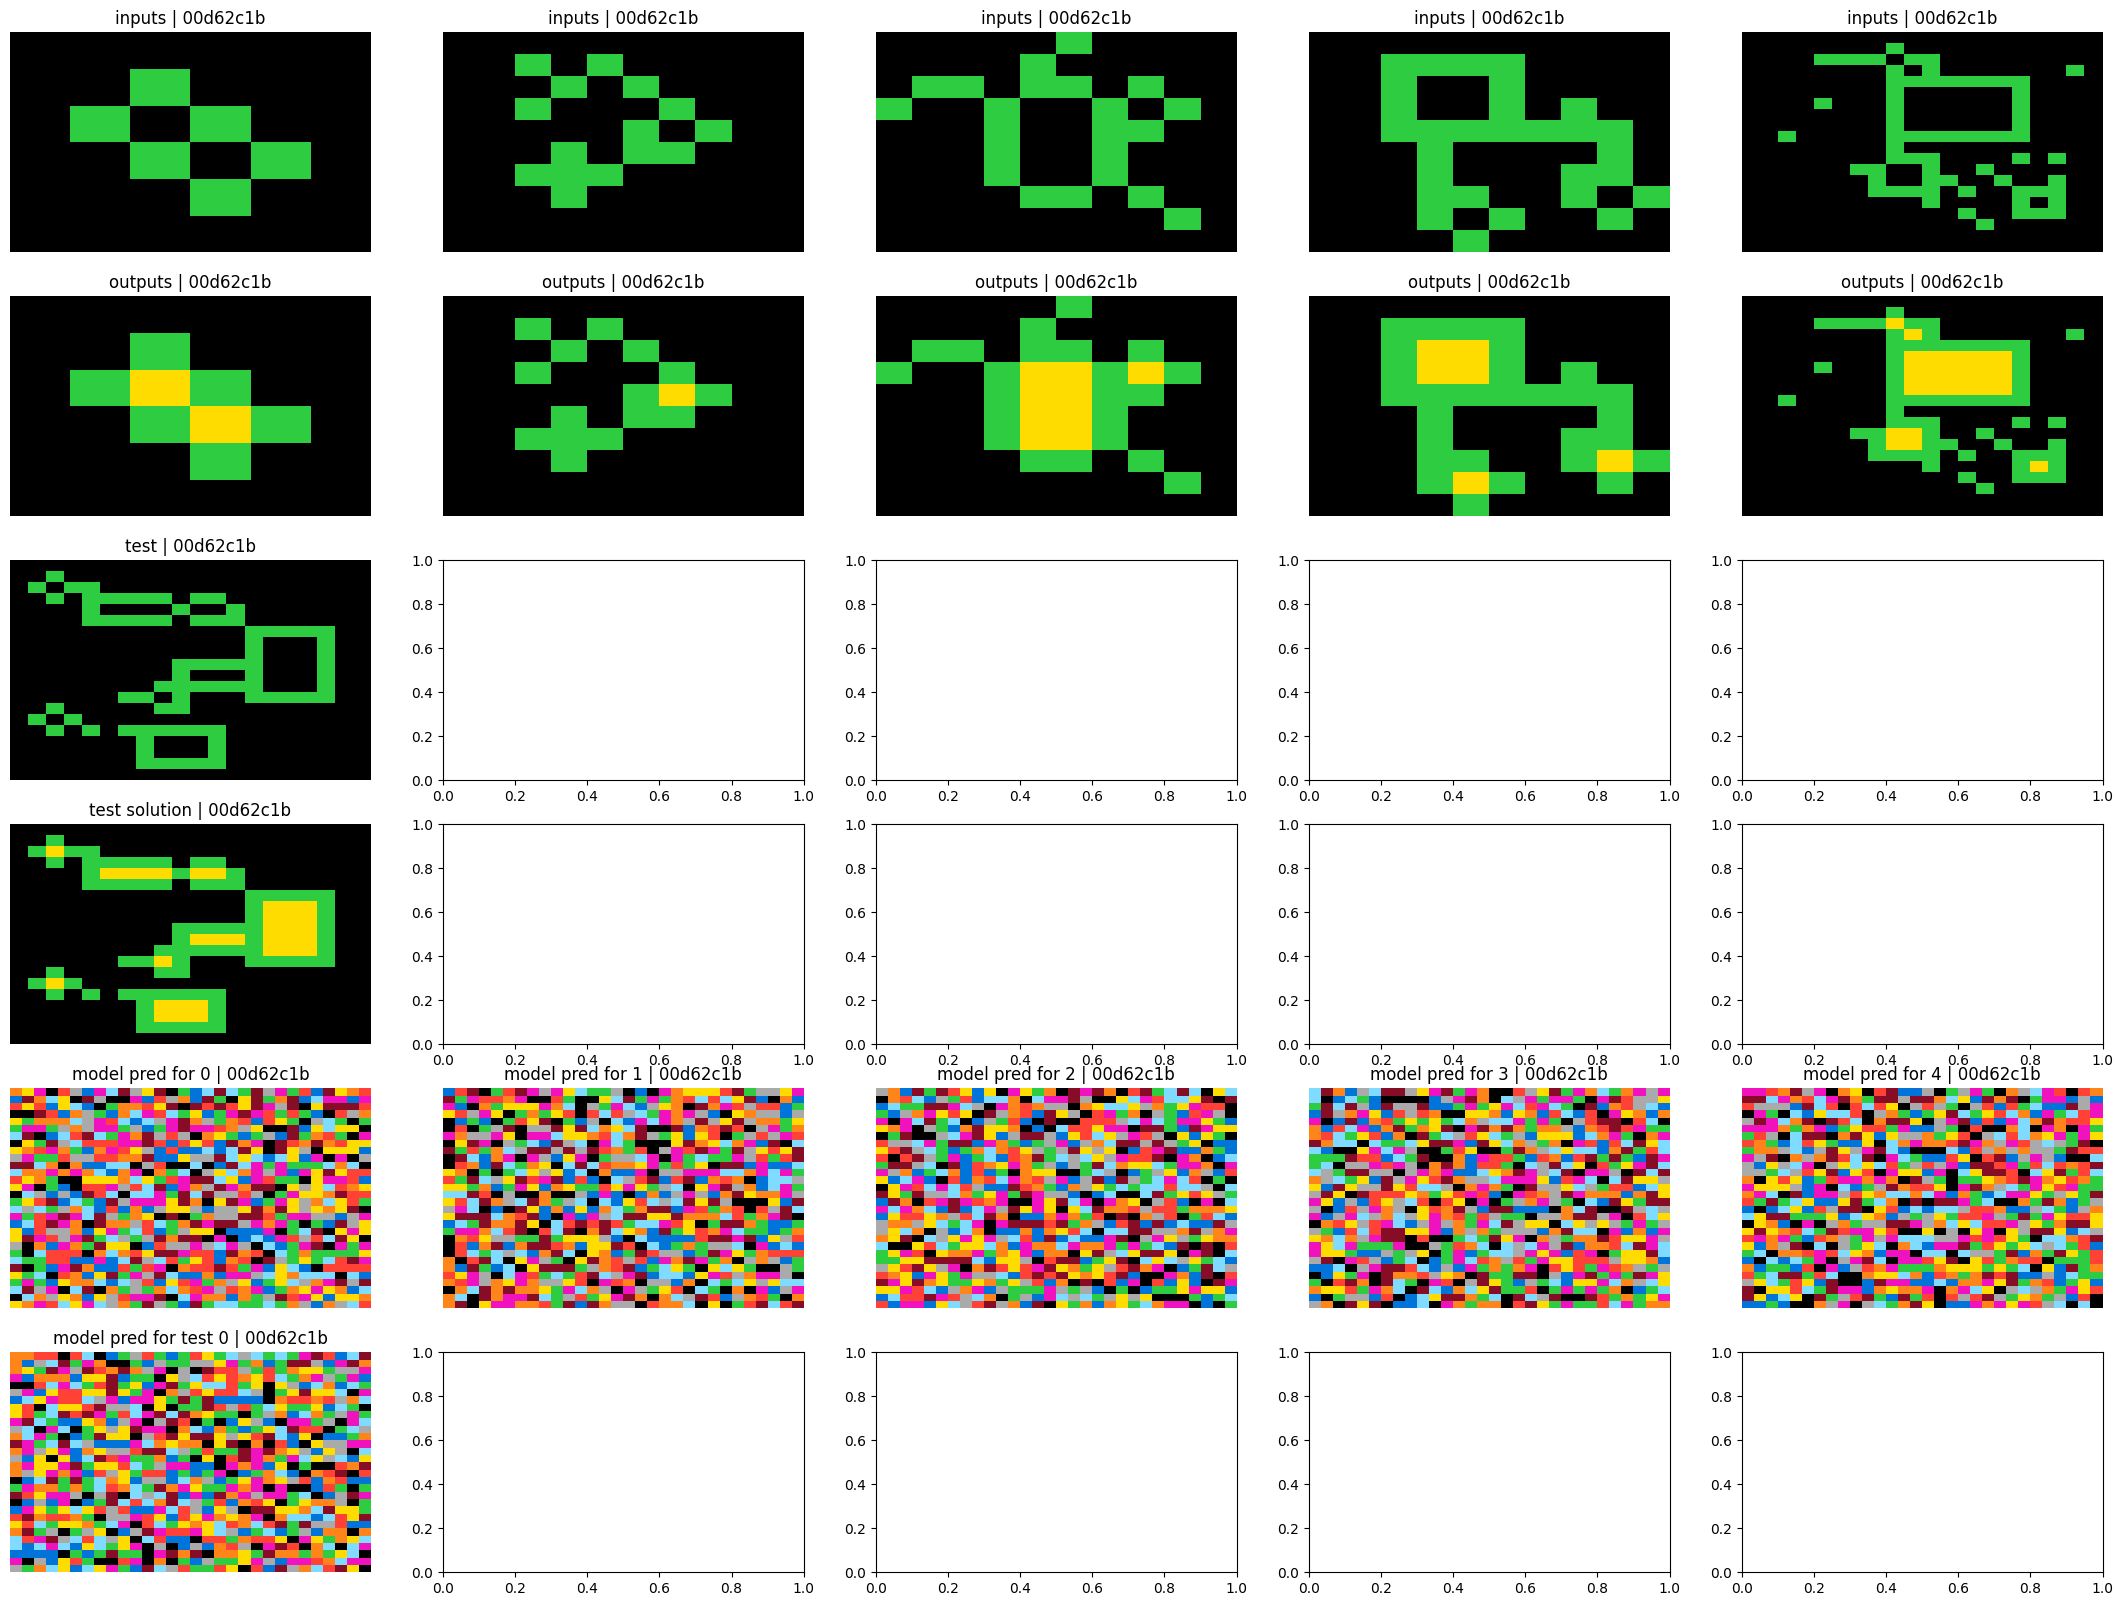

In [12]:
# view challenge also supports predictions
# test predictions is expected to be in a list (array) format, even if there is just one
print(len(ARC_train[0]["inputs"]))
preds = torch.randint(0, 10, (len(ARC_train[0]["inputs"])+len(ARC_train[0]["tests"]), 30, 30))
train_visualizer.view_challenge(challenge_idx=1, challenge_predictions=preds[:-1, :, :],test_predictions=[preds[-1, :, :]])